# Simulation 6

**Mengqi Liu**

**Aug 13， 2023**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
import torch
import estimate
import numpy as np
import igraph as ig
from itertools import permutations

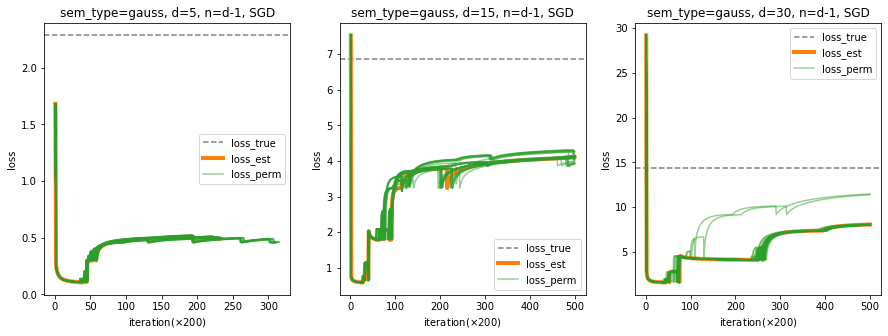

In [21]:
semtypes = ["gauss"]
ds = [5,15, 30]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
colormap = plt.cm.tab10
loss_f = ["loss_true", "loss_est"]
#losses = ["loss_est_2", "loss_l1_2", "obj_aug_", "obj_dual_2"]
#losses = ["loss_est_t", "loss_l1_t", "obj_aug_t", "obj_dual_t"]
#losses = ["h", "h_2", "h_t"]
for i, sem_type in enumerate(semtypes):
    for j, d in enumerate(ds):
        result = pd.read_csv("./results_loss/result_"+str(5001)+"_"+sem_type+"_"+str(d)+".csv")
       
        ax = axs[j]
        ax.axhline(y=result.iloc[0, 0], color='grey', linestyle='--', label=loss_f[0])
        ax.plot(np.arange(500)+1, result.iloc[1,:], marker='', label=loss_f[1], color=colormap(1), lw=4)
        for p in range(30):
            if p == 0:
                ax.plot(np.arange(500)+1, result.iloc[p+2,:], marker='', alpha=0.5, color=colormap(2), label="loss_perm")
            else:
                ax.plot(np.arange(500)+1, result.iloc[p+2,:], marker='', alpha=0.5, color=colormap(2))
        ax.set_xlabel(r'iteration($\times$200)')
        ax.set_ylabel("loss")
        ax.set_title(f'sem_type={sem_type}, d={ds[j]}, n=d-1, SGD')
        ax.legend()
plt.subplots_adjust(wspace=.2, hspace=.4)
plt.savefig("./results_loss/loss_sgd_perm.png")
plt.show()

1. Method: SGD, Adam, ...
2. $2*d*d$ w -> d*d w
3. constraint w/ or w/o grad
4. learning rate 1, 0.1, 0.05, 0.03, 0.01, 0.001

In [6]:
def is_dag(W):
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    return G.is_dag()

In [13]:
is_dag(np.tril(np.ones([10, 10]), k=-1))

True

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def count_accuracy(B_true, B_est):
    """Compute various accuracy metrics for B_est.

    true positive = predicted association exists in condition in correct direction
    reverse = predicted association exists in condition in opposite direction
    false positive = predicted association does not exist in condition

    Args:
        B_true (np.ndarray): [d, d] ground truth graph, {0, 1}
        B_est (np.ndarray): [d, d] estimate, {0, 1, -1}, -1 is undirected edge in CPDAG

    Returns:
        fdr: (reverse + false positive) / prediction positive
        tpr: (true positive) / condition positive
        fpr: (reverse + false positive) / condition negative
        shd: undirected extra + undirected missing + reverse
        nnz: prediction positive
    """
    if (B_est == -1).any():  # cpdag
        if not ((B_est == 0) | (B_est == 1) | (B_est == -1)).all():
            raise ValueError('B_est should take value in {0,1,-1}')
        if ((B_est == -1) & (B_est.T == -1)).any():
            raise ValueError('undirected edge should only appear once')
    else:  # dag
        if not ((B_est == 0) | (B_est == 1)).all():
            raise ValueError('B_est should take value in {0,1}')
        #if not is_dag(B_est):
        #    raise ValueError('B_est should be a DAG')
    d = B_true.shape[0]
    # linear index of nonzeros
    pred_und = np.flatnonzero(B_est == -1)
    pred = np.flatnonzero(B_est == 1)
    cond = np.flatnonzero(B_true)
    cond_reversed = np.flatnonzero(B_true.T)
    cond_skeleton = np.concatenate([cond, cond_reversed])
    # true pos
    true_pos = np.intersect1d(pred, cond, assume_unique=True)
    # treat undirected edge favorably
    true_pos_und = np.intersect1d(pred_und, cond_skeleton, assume_unique=True)
    true_pos = np.concatenate([true_pos, true_pos_und])
    # false pos
    false_pos = np.setdiff1d(pred, cond_skeleton, assume_unique=True)
    false_pos_und = np.setdiff1d(pred_und, cond_skeleton, assume_unique=True)
    false_pos = np.concatenate([false_pos, false_pos_und])
    # reverse
    extra = np.setdiff1d(pred, cond, assume_unique=True)
    reverse = np.intersect1d(extra, cond_reversed, assume_unique=True)
    # compute ratio
    pred_size = len(pred) + len(pred_und)
    cond_neg_size = 0.5 * d * (d - 1) - len(cond)
    fdr = float(len(reverse) + len(false_pos)) / max(pred_size, 1)
    tpr = float(len(true_pos)) / max(len(cond), 1)
    fpr = float(len(reverse) + len(false_pos)) / max(cond_neg_size, 1)
    # structural hamming distance
    pred_lower = np.flatnonzero(np.tril(B_est + B_est.T))
    cond_lower = np.flatnonzero(np.tril(B_true + B_true.T))
    extra_lower = np.setdiff1d(pred_lower, cond_lower, assume_unique=True)
    missing_lower = np.setdiff1d(cond_lower, pred_lower, assume_unique=True)
    shd = len(extra_lower) + len(missing_lower) + len(reverse)
    return {'fdr': fdr, 'tpr': tpr, 'fpr': fpr, 'shd': shd, 'nnz': pred_size}


In [18]:
w_true = np.load('w_true.npy')
w_est = np.load('w_est.npy')

In [19]:
w_est[np.abs(w_est) < 0.3] = 0

In [20]:
count_accuracy(w_est!=0, w_true!=0)

{'fdr': 0.20689655172413793,
 'tpr': 0.2072072072072072,
 'fpr': 0.018518518518518517,
 'shd': 94,
 'nnz': 29}

In [3]:
utils.set_random_seed(1)
B_true = utils.simulate_dag(10, 10, "ER", device)
W_true = utils.simulate_parameter(B_true)
X = utils.simulate_linear_sem(W_true, 9, "gauss")

learning rate = 0.03/ 0.01 

In [4]:
a = estimate.notears_linear(X, W_true=W_true, lambda1=0, loss_type="l2")

/Users/aurora/Desktop/My_files/Uchi/summer/Notears_loss/estimate.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32, device=device)


Iteration 10: Loss = 3.1068549156188965, h = 0.6904525756835938, rho = 1.0, alpha = 0.0
0.16828560829162598
Iteration 20: Loss = 2.156264066696167, h = 0.8192844390869141, rho = 1.0, alpha = 0.0
0.059973955154418945
Iteration 30: Loss = 1.757556438446045, h = 0.8823795318603516, rho = 1.0, alpha = 0.0
0.028423428535461426
Iteration 40: Loss = 1.5444560050964355, h = 0.9058246612548828, rho = 1.0, alpha = 0.0
0.01702892780303955
Iteration 50: Loss = 1.4076520204544067, h = 0.9038448333740234, rho = 1.0, alpha = 0.0
0.011742472648620605
Iteration 60: Loss = 1.3072597980499268, h = 0.8889608383178711, rho = 1.0, alpha = 0.0
0.008951783180236816
Iteration 70: Loss = 1.2277579307556152, h = 0.8701763153076172, rho = 1.0, alpha = 0.0
0.007224321365356445
Iteration 80: Loss = 1.1627061367034912, h = 0.8512783050537109, rho = 1.0, alpha = 0.0
0.0059735774993896484
Iteration 90: Loss = 1.1083736419677734, h = 0.8345346450805664, rho = 1.0, alpha = 0.0
0.005026578903198242
Iteration 100: Loss = 

In [4]:
def restore_from_per(per_ind, W):
    W_re = np.zeros(W.shape)
    for i in range(len(per_ind)):
        for j in range(len(per_ind)):
            W_re[i, j] = W[per_ind[i], per_ind[j]]
    return W_re

In [7]:
def estimate_template(sem_type, seed=1, lambda1=0, loss_type='l2', BB=100):
    print("=============processing seed=", seed, "================")
    #utils.set_random_seed(seed)
    print("=============processing seed=", seed, "================")
    d = 3
    #utils.set_random_seed(seed)
    n = 2 * d
    s0 = d-1
    print("n, d, s0, em_type, lambda1, loss_type", "-", n, d, s0, sem_type, lambda1, loss_type)
    
    B_true = torch.tensor(np.zeros([3, 3]))
    for i in range(3):
        if (i+1) % 3 == 0:
            B_true[i-1, i] = 1
            B_true[i-2, i] = 1
    W_true = utils.simulate_parameter(B_true)
    X = utils.simulate_linear_sem(W_true, n, sem_type, noise_scale=np.abs(np.random.normal(1, 1, d)))

    # B = np.min([math.factorial(d), BB])
    B = 6
    results = np.zeros([5, B+2])
    results[0, 0] = 0.5 / X.shape[0] * ((X-X@W_true) ** 2).sum()

    #all_perm = list(permutations(range(X.shape[1])))
    #utils.set_random_seed(seed+d)
    inds = [i for i in range(d)]
    w_est, _, _, _, _, _ = estimate.notears_linear(X, W_true=W_true, lambda1=0, loss_type=loss_type)
    
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  
    axes_ = axes.ravel()
    cax = axes_[0].imshow(W_true, cmap='viridis') 
    axes_[0].set_title("True W")
    plt.colorbar(cax, ax=axes_[0]) 
    count = 2
    axes_[1].axis('off')
    axes_[2].axis('off')
    for a1 in permutations(range(3)):
        count += 1
        new_ind = a1
        w_est, _, _, _, _, _ = estimate.notears_linear(X[:, new_ind], W_true=W_true, lambda1=0, loss_type="l2")
        w_est_re = restore_from_per(new_ind, w_est)
        cax = axes_[count].imshow(w_est_re, cmap='viridis') 
        plt.colorbar(cax, ax=axes_[count]) 
        axes_[count].set_title("Estimated W")
    #plt.savefig("./results_loss2/3node_perm_1.png")
    plt.show()

=============processing seed= 1 ================
=============processing seed= 1 ================
n, d, s0, em_type, lambda1, loss_type - 6 3 2 gauss 0 l2
Iteration 1: Loss = 5.113146781921387, h = 0.0, rho = 1.0, alpha = 0.0
Iteration 101: Loss = 0.13855275511741638, h = 0.5540256500244141, rho = 1.0, alpha = 0.0


/Users/aurora/Desktop/My_files/Uchi/summer/Notears_pytorch/estimate.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32, device=device)


Iteration 201: Loss = 0.12129022181034088, h = 0.5286874771118164, rho = 1.0, alpha = 0.0
Iteration 301: Loss = 0.12398337572813034, h = 0.4849128723144531, rho = 1.0, alpha = 0.0
Iteration 401: Loss = 0.11344312876462936, h = 0.4807600975036621, rho = 1.0, alpha = 0.0
Iteration 1: Loss = 0.1335277408361435, h = 0.46803760528564453, rho = 1.0, alpha = 0.46803760528564453
Iteration 101: Loss = 0.1978801190853119, h = 0.2896299362182617, rho = 1.0, alpha = 0.46803760528564453
Iteration 1: Loss = 0.13745765388011932, h = 0.46803760528564453, rho = 10.0, alpha = 0.46803760528564453
Iteration 101: Loss = 0.3512779176235199, h = 0.1344311237335205, rho = 10.0, alpha = 0.46803760528564453
Iteration 1: Loss = 0.13745765388011932, h = 0.46803760528564453, rho = 100.0, alpha = 0.46803760528564453
Iteration 101: Loss = 0.7642322778701782, h = 0.06649279594421387, rho = 100.0, alpha = 0.46803760528564453
Iteration 201: Loss = 0.5832428336143494, h = 0.0479741096496582, rho = 100.0, alpha = 0.46803

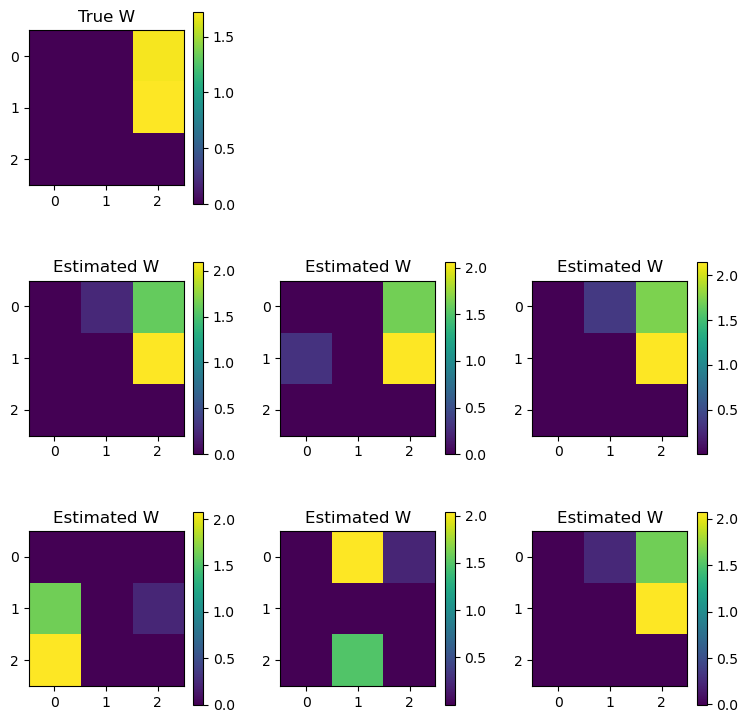

In [8]:
estimate_template("gauss", seed=1, lambda1=0, loss_type='l2', BB=100)